In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/bestbuy/notebooks/ashish


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

sys.version

sys.path.append("../../")

# from src.ad_hmm import sku_predict
# from src.ad_stl_model import stl_model
from src.utils import *

In [3]:
%load_ext autoreload 
%autoreload 

### Original Train/Test data

In [4]:
train_test = pd.read_csv("../../data/train_validation_marker.csv")
train_test["SALES_DATE"] = pd.to_datetime(train_test["SALES_DATE"])
print (train_test.shape)

train_test["if_promo"] = (~train_test["PROMO_PRICE"].isin(["?"])).astype("int")
train_test["if_competitor"] = (~train_test["COMPETITOR_PRICE"].isin(["?"])).astype("int")

train_test["min_sales_price"] = pd.to_numeric(np.where(train_test.if_promo>0, train_test.PROMO_PRICE,\
                                                       train_test.RETAIL_PRICE))

train_test["comp_price_clean"] = pd.to_numeric(np.where(train_test.if_competitor>0,train_test.COMPETITOR_PRICE, np.nan))
train_test["price_delta"] = np.where(train_test.if_competitor>0, train_test.min_sales_price - train_test.comp_price_clean,\
                                   -train_test.min_sales_price)

(846632, 15)


In [5]:
train_test_pivot = train_test.pivot(index='SALES_DATE', columns='Encoded_SKU_ID',\
                   values=['DAILY_UNITS',"if_promo","if_competitor","min_sales_price","price_delta",\
                          "validation","validation_clean"])
train_test_pivot.columns = train_test_pivot.columns.swaplevel(0, 1)

### Read pickle results

In [6]:
import pickle
with open('../../data/stl_prophet_results_v1.pkl', 'rb') as f:
    all_preds = pickle.load(f)
    
y_pred_df = pd.DataFrame()
for i in range(len(all_preds)):
    if all_preds[i]!= None:
        y_pred_df = pd.concat([y_pred_df,all_preds[i][1]])    

Importing plotly failed. Interactive plots will not work.


In [7]:
validation = train_test[(train_test.validation==True) & (train_test.validation_clean==True)]
y_act = validation[["Encoded_SKU_ID","SALES_DATE","DAILY_UNITS"]].rename(columns = {"DAILY_UNITS":"actual"})
y_act["actual"] = pd.to_numeric(y_act["actual"])
y_act.head()

,Encoded_SKU_ID,SALES_DATE,actual
100,96,2022-07-27,2
218,187,2022-07-29,0
420,297,2022-07-29,6
652,372,2022-07-27,1
831,412,2022-07-26,4


### Null, STL/MSTL/Prophet, HMM and holt winters

In [8]:
y_pred_null = pd.read_csv("../../data/null_prediction_validation_result_v0.csv").drop(columns = "Unnamed: 0")
y_pred_null["SALES_DATE"] = pd.to_datetime(y_pred_null["SALES_DATE"])

In [9]:
y_pred_stl = y_pred_df.reset_index()[["SALES_DATE","STL_prediction","Encoded_SKU_ID"\
                        ]].rename(columns={"STL_prediction":"predicted"})

y_pred_mstl = y_pred_df.reset_index()[["SALES_DATE","MSTL_prediction","Encoded_SKU_ID"\
                        ]].rename(columns={"MSTL_prediction":"predicted"})

y_pred_prophet = y_pred_df.reset_index()[["SALES_DATE","prophet_prediction","Encoded_SKU_ID"\
                        ]].rename(columns={"prophet_prediction":"predicted"})

In [10]:
y_pred_holt = pd.read_csv("../../data/ES_pred.csv").drop(columns=["Unnamed: 0"])
y_pred_holt["SALES_DATE"] = pd.to_datetime(y_pred_holt["SALES_DATE"])

In [11]:
# VERSION = "v2"
# hmm_output = pd.read_csv(f"../../data/hmm_result_{VERSION}.csv",index_col=0)

### Join the data

In [12]:
print("null",y_pred_null["Encoded_SKU_ID"].nunique())
print("stl",y_pred_stl["Encoded_SKU_ID"].nunique())
print("mstl",y_pred_mstl["Encoded_SKU_ID"].nunique())
print("holt",y_pred_holt["Encoded_SKU_ID"].nunique())
# print("hmm",hmm_output["Encoded_SKU_ID"].nunique())
print("prophet",y_pred_prophet["Encoded_SKU_ID"].nunique())

null 545
stl 503
mstl 503
holt 545
prophet 503


In [13]:
# hmm_output1 = hmm_output.reset_index(names="SALES_DATE")
# hmm_output1["SALES_DATE"] = pd.to_datetime(hmm_output1["SALES_DATE"])
y_pred_holt1 = y_pred_holt.rename(columns={"predicted":"predicted_holt"})

In [14]:
all_predictions = y_pred_df.reset_index().merge(y_pred_holt,on=["Encoded_SKU_ID","SALES_DATE"],how="outer"\
                                               ).merge(y_pred_null,on=["Encoded_SKU_ID","SALES_DATE"],how="outer",\
                                                   suffixes = ("_holt","_null"),\
                                                   ).drop(columns="actual")

In [15]:
all_predictions.head()

,SALES_DATE,STL_prediction,MSTL_prediction,prophet_prediction,Encoded_SKU_ID,predicted_holt,predicted_null
0,2022-07-25,1.139742,1.562445,1.662813,1,2.006318,1
1,2022-07-26,2.706996,1.328076,1.256640,1,2.104498,1
2,2022-07-27,1.287372,1.550463,1.314178,1,2.536772,1
3,2022-07-28,1.401008,2.986880,1.533027,1,2.601272,1
4,2022-07-29,2.200458,2.243526,2.250344,1,2.003338,1


In [16]:
all_predictions = all_predictions.rename(columns={
    "STL_prediction":"predicted_STL",\
    "MSTL_prediction":"predicted_MSTL",\
    "prophet_prediction":"predicted_prophet"
})

### RMSE for each col

In [17]:
rmse_all_preds = pd.DataFrame()
first_flag = True
for col in all_predictions.columns:
    if "pred" in col:
        y_pred_i = all_predictions[["Encoded_SKU_ID","SALES_DATE",col\
                                   ]].rename(columns={col:"predicted"})
        y_pred_i["SALES_DATE"] = pd.to_datetime(y_pred_i["SALES_DATE"])
        rmse_pred_i = rmse_sku(y_act,y_pred_i)
        rmse_pred_i.columns = [f"{col_rmse}_{col.split('_')[-1]}" for col_rmse in rmse_pred_i.columns]
        if first_flag:
            rmse_all_preds = rmse_pred_i
            print (col,rmse_all_preds.shape)
            first_flag = False
        else:
            rmse_all_preds = rmse_all_preds.merge(rmse_pred_i, left_index = True, right_index = True,\
                                suffixes = ("",f"_{col.split('_')[-1]}"))
            print (col,rmse_all_preds.shape)

predicted_STL (545, 3)
predicted_MSTL (545, 6)
predicted_prophet (545, 9)
predicted_holt (545, 12)
predicted_null (545, 15)


In [18]:
rmse_all_preds

,rmse_du_STL,mean_du_STL,pct_rmse_STL,rmse_du_MSTL,mean_du_MSTL,pct_rmse_MSTL,rmse_du_prophet,mean_du_prophet,pct_rmse_prophet,rmse_du_holt,mean_du_holt,pct_rmse_holt,rmse_du_null,mean_du_null,pct_rmse_null
Encoded_SKU_ID,,,,,,,,,,,,,,,
237,167.832345,4.142857,40.511256,125.232018,4.142857,30.228418,322.925792,4.142857,77.947605,373.839838,4.142857,90.237202,3.443420,4.142857,0.831170
469,93.126495,450.857143,0.206554,197.100151,450.857143,0.437168,86.072058,450.857143,0.190908,201.944182,450.857143,0.447912,129.112354,450.857143,0.286371
347,53.613060,3.571429,15.011657,94.448813,3.571429,26.445668,79.745380,3.571429,22.328707,202.611461,3.571429,56.731209,2.751623,3.571429,0.770454
430,41.161657,133.714286,0.307833,41.312379,133.714286,0.308960,68.295201,133.714286,0.510755,26.140336,133.714286,0.195494,18.551088,133.714286,0.138737
502,24.192927,21.000000,1.152044,20.002315,21.000000,0.952491,23.103827,21.000000,1.100182,47.401507,21.000000,2.257215,12.961481,21.000000,0.617213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,NaN,70.571429,NaN,NaN,70.571429,NaN,NaN,70.571429,NaN,144.060478,70.571429,2.041343,30.460748,70.571429,0.431630
560,NaN,1.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,0.827778,1.000000,0.827778,0.534522,1.000000,0.534522
566,NaN,5.571429,NaN,NaN,5.571429,NaN,NaN,5.571429,NaN,15.125061,5.571429,2.714755,2.507133,5.571429,0.449998


In [19]:
rmse_cols = [col for col in rmse_all_preds.columns if "rmse_du" in col]
rmse_cols

['rmse_du_STL',
 'rmse_du_MSTL',
 'rmse_du_prophet',
 'rmse_du_holt',
 'rmse_du_null']

In [20]:
rmse_all_preds["min_rmse"] = rmse_all_preds[rmse_cols].min(axis=1,skipna=True)

rmse_all_preds["argmin_period"] = np.argmin(rmse_all_preds[rmse_cols].values,axis=1)

rmse_all_preds["min_period"] = rmse_all_preds["argmin_period"].apply(lambda x: rmse_cols[x])

In [21]:
period_col_map= {
    "rmse_du_15":"predicted_15", "rmse_du_30":"predicted_30", "rmse_du_45":"predicted_45",\
    "rmse_du_60":"predicted_60", "rmse_du_90":"predicted_90", "rmse_du_max":"predicted_max",\
    "rmse_du_STL":"predicted_STL","rmse_du_MSTL":"predicted_MSTL","rmse_du_null":"predicted_null",\
    "rmse_du_holt":"predicted_holt","rmse_du_prophet":"predicted_prophet"
}

In [22]:
y_pred_best = pd.DataFrame()
cnt = 0
for sku_id,best_period in zip(rmse_all_preds.index,rmse_all_preds["min_period"]):
    best_col = period_col_map[best_period]
    mask_sku = all_predictions.Encoded_SKU_ID==sku_id
    y_pred_best_sku = all_predictions.loc[mask_sku][["Encoded_SKU_ID","SALES_DATE",best_col\
                                                                  ]].rename(columns={best_col:"predicted"})
    y_pred_best = pd.concat([y_pred_best,y_pred_best_sku])

In [23]:
#QC
y_act.Encoded_SKU_ID.nunique(),y_pred_null.Encoded_SKU_ID.nunique(),y_pred_best.Encoded_SKU_ID.nunique()

(545, 545, 545)

In [24]:
rmse_val_null,rmse_null_best = rmse(y_act,y_pred_null),rmse(y_act,y_pred_best)
rmse_val_null,rmse_null_best

(6.59603916258372, 4.423088512745915)

In [25]:
(rmse_val_null-rmse_null_best)/rmse_val_null

0.32943264833294944

In [26]:
rmse_all_preds["min_period"].value_counts()

rmse_du_null       180
rmse_du_STL        152
rmse_du_prophet    121
rmse_du_holt        53
rmse_du_MSTL        39
Name: min_period, dtype: int64

### Analysis

In [27]:
sku_period_dict = rmse_all_preds.reset_index().groupby("min_period")["Encoded_SKU_ID"].apply(list)

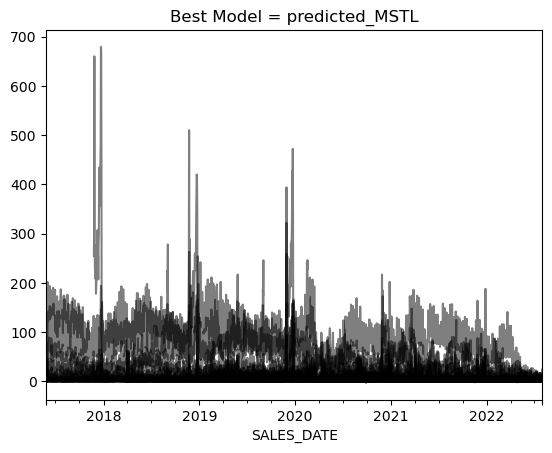

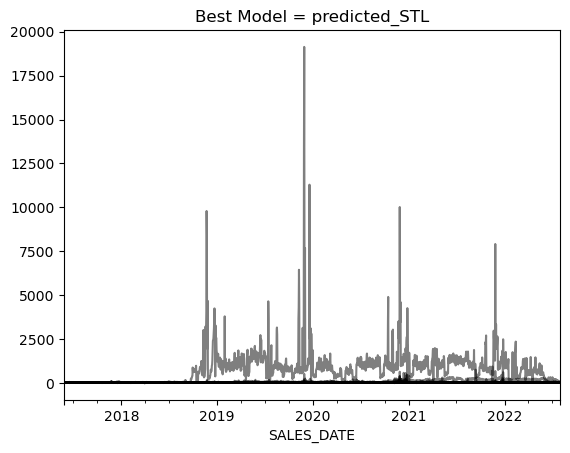

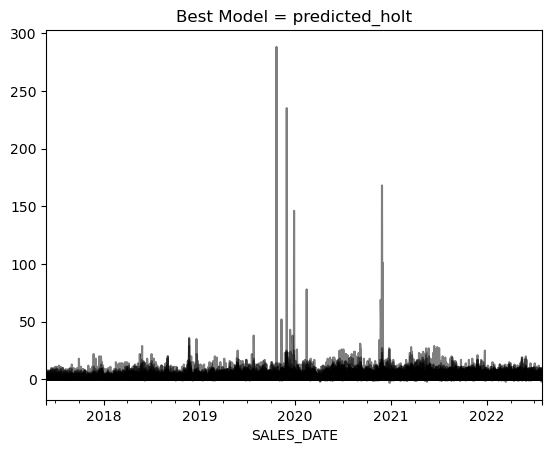

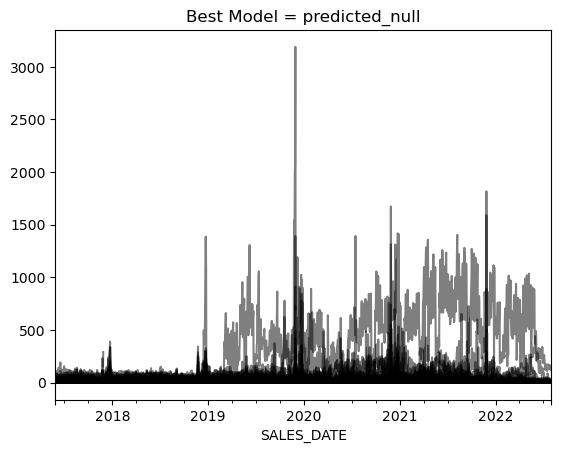

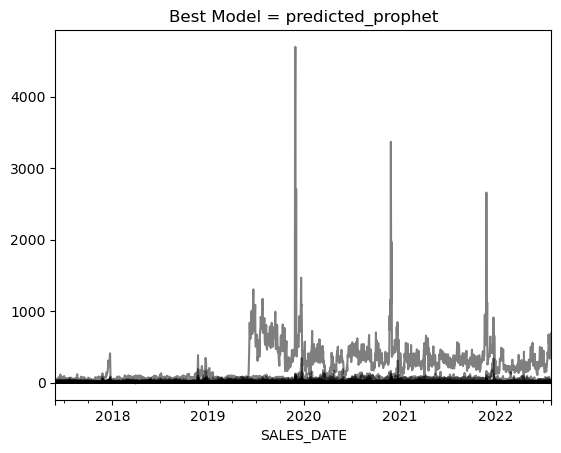

In [28]:
for min_period,sku_list in sku_period_dict.items():
#     print (min_period)
    mask = train_test["Encoded_SKU_ID"].isin(sku_list)
    train_subset = train_test.loc[mask]
    train_subset_pivot = train_subset.pivot(index='SALES_DATE', columns='Encoded_SKU_ID', values='DAILY_UNITS')
    train_subset_pivot.plot(alpha=0.5,color="black",legend=False)
    plt.title(f"Best Model = {period_col_map[min_period]}")
#     plt.legend()
#     train_test[["SUBCLASS_NAME","CLASS_NAME","ML_NAME","COMPETITOR_PRICE"]].value_counts()